In [1]:
from tile_coding import TileCoder
from semi_gradient_sarsa import semi_gradient_sarsa
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
# Helper function to generate videos

def generate_video(
    frames:list,
    output_name:str='output.mp4',
    fps:float=10, 
    shape:tuple=(600, 400)
):
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    video_writer = cv2.VideoWriter(output_name, fourcc, fps, shape)
    for frame in frames:
        frame = frame[:, :, ::-1]
        video_writer.write(frame)
    video_writer.release()

In [ ]:
# Implementation based on SAB
coder = TileCoder(
    low=[-1.2, -0.07],
    high=[0.6, 0.07],
    num_tiles=8,
    tile_per_dimension=[8, 8]
)

num_actions = 3
env = gym.make('MountainCar-v0', render_mode='rgb_array')

In [4]:
def experiment_10_2(
    alpha:float,
    coder:TileCoder,
    env:gym.Env,
    num_actions:int=3,
    episodes:int=500,
    runs:int=100
):
    total_history = np.zeros(episodes)
    for _ in range(runs):
        _, history = semi_gradient_sarsa(
            env=env,
            tile_coder=coder,
            num_actions=num_actions,
            epsilon=0.0,
            episodes=episodes,
            alpha=alpha
        )
        total_history += history
    
    return total_history / runs


## Figure 10.2

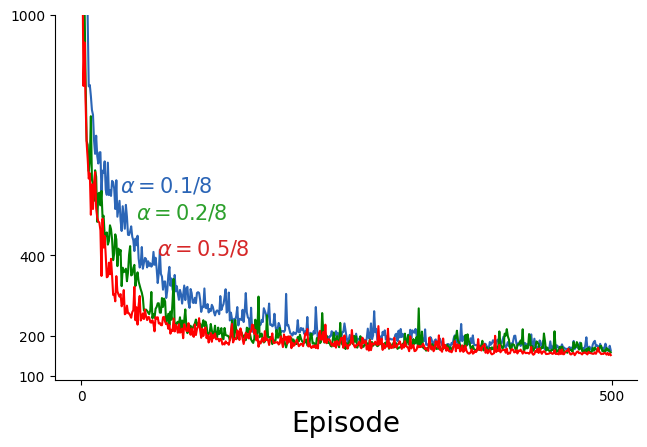

In [ ]:
print('alpha=0.1/8')
alpha01 = experiment_10_2(0.1/8, coder, env=env, episodes=500, runs=100)
print('alpha=0.2/8')
alpha02 = experiment_10_2(0.2/8, coder, env=env, episodes=500, runs=100)
print('alpha=0.5/8')
alpha05 = experiment_10_2(0.5/8, coder, env=env, episodes=500, runs=100)

fig = plt.figure()
ax = plt.subplot(111)
ax.plot(alpha01, c='#2b65b6')
ax.plot(alpha02, c='green')
ax.plot(alpha05, c='red')
ax.set_xticks([0, 500])
ax.set_ylim([90, 1000])
ax.set_yticks([100, 200, 400, 1000])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

x_inter = 50
offset_points = 40
alpha01_inter = np.interp(x_inter, range(500), alpha01)
alpha02_inter = np.interp(x_inter, range(500), alpha02)
alpha05_inter = np.interp(x_inter, range(500), alpha05)

# Annotations
ax.annotate(r"$\alpha=0.1/8$", 
            xy=(x_inter + 30, alpha01_inter), 
            xytext=(0, offset_points), 
            textcoords="offset points",
            color='#2b65b6',
            fontsize=15,
            ha='center', va='bottom'
            )

ax.annotate(r"$\alpha=0.2/8$", 
            xy=(x_inter + 45, alpha02_inter), 
            xytext=(0, offset_points-10), 
            textcoords="offset points",
            color='#2ca02c',
            fontsize=15,
            ha='center', va='bottom'
            )

ax.annotate(r"$\alpha=0.5/8$", 
            xy=(x_inter + 65, alpha05_inter), 
            xytext=(0, offset_points-20), 
            textcoords="offset points",
            color='#d62728',
            fontsize=15,
            ha='center', va='bottom'
            )

ax.set_xlabel("Episode", fontsize=20)
ax.set_ylabel("")  # no y-label in reference image

plt.subplots_adjust(left=0.07, right=0.98, top=0.92, bottom=0.16)

In [12]:
# Train
w, _ = semi_gradient_sarsa(
    env=env,
    tile_coder=coder,
    num_actions=3,
    epsilon=0.0,
    episodes=1000,
    alpha=0.5/8
)

# Play
frames = []
state = env.reset()[0]
frames.append(env.render())
terminated = False

while not terminated:
    x = coder.get_vector(state)
    actions = w.T @ x
    best_action = np.argmax(actions)
    state, reward, terminated, _, _ = env.step(best_action)
    frames.append(env.render())

generate_video(
    frames=frames
)